In [1]:
import pandas as pd
import numpy as np
import os
import re

## Loading data

In [2]:
# load data into pandas
def read_data(dir_path):
    examples = []
    for filename in os.listdir(dir_path):
        if not filename.endswith("txt"):
            continue
        keys = filename.split(".")[0].split("_")
        assert len(keys) == 3
        # keys is [id, label, review_score]. For now we are only interested in the label
        label = keys[1]
        with open(os.path.join(dir_path, filename)) as f:
            text = f.read().strip().replace("<br />", " ")
        examples.append([text, 1 if label == 'pos' else 0])
    return examples

In [3]:
DEV_SIZE = 800

In [4]:
SDEV_DIR = '../imdb-data/sd{}'.format(DEV_SIZE)
sdev_data = read_data(SDEV_DIR)
sdev_df = pd.DataFrame(sdev_data, columns=['text', 'label'])
sdev_df

,text,label
0,It's beyond my comprehension that so much rubb...,1
1,'What I Like About You' is definitely a show t...,1
2,"ELVIRA, MISTRESS OF THE DARK (1988) directed ...",1
3,This is one of the most spiritual movies I hav...,1
4,"Man With the Gun is pretty much forgotten now,...",1
...,...,...
795,Police Story is one of Jackie Chan's classic f...,1
796,If you need cheering up on a cold weekday even...,1
797,A wonderful early musical film from Rene Clair...,1
798,"A light-hearted comedy, Nothing shows us a wor...",1


In [5]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = '../imdb-data/og'
train_data = read_data(TRAIN_DIR)

all_train_df = pd.DataFrame(train_data, columns=['text', 'label'])
train_df = pd.concat([all_train_df, sdev_df]).drop_duplicates(keep=False)
train_df

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
5,"""Hatred of a Minute"" is arguably one of the be...",1
...,...,...
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,1
24997,I really enjoyed The 60's. Not being of that g...,1
24998,"While on a vacation at the beach, red-haired b...",0


## Get most indicative words using Naive Bayes on sdevset

In [6]:
from naive_bayes.imdb import return_keywords_indices

all_words, most_pos_indices, most_neg_indices = return_keywords_indices(sdev_data)

Size of dictionary:  3064


In [7]:
NUM_KEYWORDS = 50

top_pos_words = [all_words[ind] for ind in most_pos_indices[:NUM_KEYWORDS]]
top_neg_words = [all_words[ind] for ind in most_neg_indices[:NUM_KEYWORDS]]

In [8]:
print('Top pos words:')
print(top_pos_words)
print('\nTop neg words:')
print(top_neg_words)

# Remember to post-process these by removing those words that are correlational but not causal, e.g. 'germany'

Top pos words:
['eddie', 'jackie', 'everyday', 'douglas', 'ned', 'cold', 'stands', 'wonderful', 'built', 'wonderfully', 'spy', 'daniel', 'gorgeous', 'finest', 'delightful', 'thrillers', 'professional', 'wall', 'adapted', 'captures', 'glory', 'genuine', 'lonely', 'saturday', 'studios', 'counter', 'quiet', 'captivating', 'strength', 'uncut', 'develops', 'california', 'lucky', 'paris', 'stunning', 'captured', 'flight', 'lovers', 'sentimental', 'mrs', 'critical', 'underground', 'intensity', 'portrait', 'gordon', 'melodrama', 'chan', 'delight', 'brilliantly', 'builds']

Top neg words:
['terrible', 'disappointing', 'waste', 'disappointment', 'lowbudget', 'villains', '310', 'darkness', 'ridiculous', 'nonexistent', 'pointless', 'mess', 'joe', 'garbage', 'toilet', 'ape', 'forgettable', 'juvenile', 'amateur', 'remotely', 'incomprehensible', 'horrendous', 'zero', 'unwatchable', 'ugly', 'gotta', 'offended', 'unintentional', 'atrocious', 'realized', 'outer', 'promise', 'cheated', 'wasted', 'tarzan'

In [9]:
pos_words = set(['eddie', 'jackie', 'everyday', 'douglas', 'cold', 
                 'stands', 'ned', 'wonderful', 'spy', 'built', 
                 'wonderfully', 'wall', 'daniel', 'finest', 'thrillers',
                 'gorgeous', 'delightful', 'professional', 'lonely', 'genuine',
                 'captures', 'saturday', 'glory', 'adapted', 'counter', 'captivating',
                 'california', 'develops', 'lucky', 'strength', 'studios', 'uncut',
                 'quiet', 'stunning', 'paris', 'flight', 'gordon', 'underground',
                 'builds', 'brilliantly', 'captured', 'mrs', 'covered', 'portrait',
                 'delight', 'lovers', 'critical', 'intensity', 'melodrama', 'sentimental'])

neg_words = set(['terrible', 'disappointing', 'waste', 'lowbudget', '310', 'darkness',
                 'villains', 'disappointment', 'nonexistent', 'ridiculous', 'pointless',
                 'joe', 'mess', 'ape', 'horrendous', 'forgettable', 'juvenile', 'garbage',
                 'amateur', 'incomprehensible', 'remotely', 'toilet', 'zero', 'offended',
                 'gotta', 'unwatchable', 'realized', 'unintentional', 'outer', 'cheated',
                 'wasted', 'atrocious', 'ugly', 'promise', 'tarzan', 'awful', 'jane',
                 'looked', 'law', 'worst', 'pretentious', 'subjected', 'secondly',
                 'amazed', 'blatantly', 'riding', 'employed', 'woody', 'plague', 'incoherent'])

## Labeling functions

In [10]:
# define constants to represent class labels
ABSTAIN = -1
POS = 1
NEG = 0

In [11]:
DISTANCE = 8

In [12]:
from snorkel.labeling import labeling_function

neg_adjs = set([
    'bad', 'worst', 'horrible', 'terrible', 'stupid', 'boring', 'dreadful', 'disgust',
    'disturbing', 'problem', 'disaster', 'a waste', 'not a fan'
])

@labeling_function()
def neg_adj(x):
    text = x.text.lower()
    for word in neg_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return NEG
    return ABSTAIN


@labeling_function()
def detect_pos_words_from_naive_bayes(x):
    return POS if any(re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) \
                      for word in pos_words) else ABSTAIN
    #return POS if any(word in x.text.lower() for word in pos_words) else ABSTAIN

@labeling_function()
def detect_neg_words_from_naive_bayes(x):
    return NEG if any(re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) \
                      for word in neg_words) else ABSTAIN
    #return NEG if any(word in x.text.lower() for word in neg_words) else ABSTAIN
    
@labeling_function()    
def detect_pos_exclamation(x):
    return POS if all(not re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) for word in neg_words) \
                    and '!' in x.text.lower() else ABSTAIN
@labeling_function()                      
def detect_neg_exclamation(x):
    return NEG if all(not re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) for word in pos_words) \
                    and '!' in x.text.lower() else ABSTAIN

@labeling_function()
def score_keywords(x):
    text = x.text.lower()
    pos_word_score = 1.0
    neg_word_score = -1.0
    score = 0
    for word in pos_words:
        if re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', text):
            score += pos_word_score
    for word in neg_words:
        if re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', text):
            score += neg_word_score
    if score > 0:
        return POS
    elif score < 0:
        return NEG
    return ABSTAIN

zero_score = r'0(( out of )|/)10'
neg_score = r'[1-4](( out of )|/)10'
pos_score = r'[6789](( out of )|/)10'
full_score = r'10(( out of )|/)10'
@labeling_function()
def find_user_review_score(x):
    if re.search(neg_score, x.text.lower()) :
        return NEG
    elif re.search(pos_score, x.text.lower()) or re.search(full_score, x.text.lower()):
        return POS
    elif re.search(zero_score, x.text.lower()):
        # we know there's no full score
        return NEG
    return ABSTAIN


## Applying and tuning LFs

In [13]:
lfs = [neg_adj, 
       detect_pos_words_from_naive_bayes, detect_neg_words_from_naive_bayes,
       detect_pos_exclamation, score_keywords, find_user_review_score]

In [14]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

applier = PandasLFApplier(lfs=lfs)

In [15]:
L_sdev = applier.apply(df=sdev_df)
LFAnalysis(L=L_sdev, lfs=lfs).lf_summary(Y=np.asarray(sdev_df["label"]))

100%|██████████| 800/800 [00:05<00:00, 153.96it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
neg_adj,0,[0],0.44625,0.35750,0.11625,251,106,0.703081
detect_pos_words_from_naive_bayes,1,[1],0.26000,0.26000,0.09250,200,8,0.961538
detect_neg_words_from_naive_bayes,2,[0],0.37375,0.37375,0.04000,262,37,0.876254
detect_pos_exclamation,3,[1],0.19875,0.11500,0.05750,121,38,0.761006
score_keywords,4,"[0, 1]",0.58250,0.58250,0.08125,450,16,0.965665
find_user_review_score,5,"[0, 1]",0.07375,0.06375,0.01875,54,5,0.915254


In [16]:
L_train = applier.apply(df=train_df)
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

100%|██████████| 24016/24016 [02:44<00:00, 146.12it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
neg_adj,0,[0],0.445286,0.364340,0.170053
detect_pos_words_from_naive_bayes,1,[1],0.298842,0.298842,0.168221
detect_neg_words_from_naive_bayes,2,[0],0.395944,0.395944,0.120711
detect_pos_exclamation,3,[1],0.192205,0.108844,0.062000
score_keywords,4,"[0, 1]",0.520778,0.520778,0.114923
find_user_review_score,5,"[0, 1]",0.083195,0.068205,0.031979


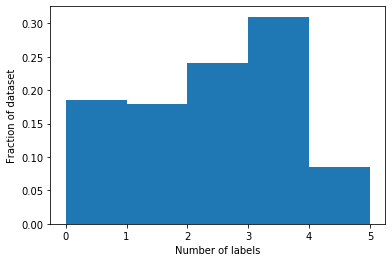

In [17]:
import matplotlib.pyplot as plt
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Testing Majority Vote (baseline) on sdev set

In [18]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
majority_acc = majority_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   88.1%


In [19]:
# Attention: this part is pseudo-cheating!

majority_model_test_acc = majority_model.score(L=L_train, Y=np.asarray(train_df["label"]))['accuracy']
print(f"{'Majority Vote Accuracy:':<25} {majority_model_test_acc * 100:.1f}%")

Majority Vote Accuracy:   76.8%


## Training Generative Model on train set and testing it on sdev set

In [20]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2)
label_model.fit(L_train=L_train, n_epochs=50, lr=.01, log_freq=1)

In [21]:
label_model.get_weights()

array([0.71597678, 0.95419725, 1.        , 0.84023954, 1.        ,
       0.79090039])

In [22]:
label_model_perf = label_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))
print(label_model_perf)

{'accuracy': 0.8590909090909091}


In [23]:
# Attention: this part is pseudo-cheating!

label_model_test_perf = label_model.score(L=L_train, Y=np.asarray(train_df["label"]))
print(label_model_test_perf)

{'accuracy': 0.7289356701241633}


## Filtering out unlabeled data points

In [24]:
from snorkel.labeling import filter_unlabeled_dataframe

In [25]:
model = label_model

### Filter

In [26]:
preds_train = model.predict(L=L_train)

In [43]:
df = train_df
df['snorkel_label'] = preds_train
df

,text,label,snorkel_label
0,I have to start saying it has been a long time...,1,1
1,I thought that Mukhsin has been wonderfully wr...,1,1
2,First of all this was not a three hour movie -...,1,1
3,I cant understand at all why so many Godzilla ...,0,0
5,"""Hatred of a Minute"" is arguably one of the be...",1,1
...,...,...,...
24994,I agree with other users comments in that the ...,0,0
24995,This movie is about this wimpy guy who decides...,1,1
24997,I really enjoyed The 60's. Not being of that g...,1,1
24998,"While on a vacation at the beach, red-haired b...",0,1


In [44]:
df_output = df[df['snorkel_label'] != -1]
df_output

,text,label,snorkel_label
0,I have to start saying it has been a long time...,1,1
1,I thought that Mukhsin has been wonderfully wr...,1,1
2,First of all this was not a three hour movie -...,1,1
3,I cant understand at all why so many Godzilla ...,0,0
5,"""Hatred of a Minute"" is arguably one of the be...",1,1
...,...,...,...
24993,I managed to catch a late night double feature...,1,1
24994,I agree with other users comments in that the ...,0,0
24995,This movie is about this wimpy guy who decides...,1,1
24997,I really enjoyed The 60's. Not being of that g...,1,1


## Export dataframe

In [47]:
df_export = df_output.drop(columns=['label'])
df_export

,text,snorkel_label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
5,"""Hatred of a Minute"" is arguably one of the be...",1
...,...,...
24993,I managed to catch a late night double feature...,1
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,1
24997,I really enjoyed The 60's. Not being of that g...,1


In [48]:
export_path = '../imdb-data/wd01.csv'
df_export.to_csv(export_path, header=False, index=False)

## Label Quality Analysis

In [29]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(list(df_output['label']), list(df_output['snorkel_label'])))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76     10531
           1       0.72      0.67      0.70      9040

    accuracy                           0.73     19571
   macro avg       0.73      0.72      0.73     19571
weighted avg       0.73      0.73      0.73     19571

